In [41]:
import numpy as np
import matplotlib.pyplot as plt
from prettytable import PrettyTable 

In [263]:
# a1 = 0.0134
a1 = 0.1
b1 = 1
c1 = 4.35e-4
m1 = 1
u0 = 300
a = 10
b = 10
x0 = 5
z0 = 5
f0 = 30
beta = 1
F0 = 1
F0_1 = 10
x_min = 0
z_min = 0

alpha_1 = 1
alpha_2 = 1
alpha_3 = 1
alpha_4 = 1

EPS = 1e-1
MAX_ITER = 100

In [230]:
x_start = x_min
z_start = z_min
x_end = a
z_end = b

h_x = 0.1
h_z = 0.1
N = int(((x_end - x_start) / h_x) + 1)
M = int(((z_end - z_start) / h_z) + 1)
tau = 5

In [44]:
def _lambda(y):
    return a1 * (b1 + c1 * (y ** m1))

def _f(x, z):
    return f0 * np.exp(-beta * (np.power(x - x0, 2) + np.power(z - z0, 2)))

def kappa(y1, y2):
    return (_lambda(y1) + _lambda(y2)) / 2

In [213]:
def x_left_bound(z_cur, y_0k, y_1k, y_0k_prev, y_1k_prev):
    # k0k = 3/(8*tau) + alpha_1/h_x + kappa(y_0k, y_1k)/np.power(h_x, 2)
    # m0k = 1/(8*tau) - kappa(y_0k, y_1k)/np.power(h_x, 2)
    # p0k = (3*y_0k_prev + y_1k_prev) / (8*tau) + u0*alpha_1/h_x + (3*_f(x_start, z_cur) + _f(x_start + h_x, z_cur))/16
    # 
    # k0k = 3/(8*tau) + kappa(y_0k, y_1k)/np.power(h_x, 2)
    # m0k = 1/(8*tau) - kappa(y_0k, y_1k)/np.power(h_x, 2)
    # p0k = (3*y_0k_prev + y_1k_prev) / (8*tau) + F0/h_x + (3*_f(x_start, z_cur) + _f(x_start + h_x, z_cur))/16
    # ---
    # k0k = 3*h_x*h_z/8 + kappa(y_0k, y_1k)*h_z*tau/h_x + alpha_1*tau*h_z
    # m0k = h_x*h_z/8 - kappa(y_0k, y_1k)*h_z*tau/h_x
    # p0k = h_x*h_z*(y_0k_prev+y_1k_prev)/8 + h_x*h_z*y_0k_prev/4 + tau*h_x*h_z/8*(_f(x_start, z_cur) + (_f(x_start, z_cur) + _f(x_start+h_x, z_cur))/2) + alpha_1*tau*h_z*u0

    k0k = 3*h_x*h_z/8 + kappa(y_0k, y_1k)*h_z*tau/h_x
    m0k = h_x*h_z/8 - kappa(y_0k, y_1k)*h_z*tau/h_x
    p0k = h_x*h_z*(3*y_0k_prev+y_1k_prev)/8 + (3*_f(x_start, z_cur) + _f(x_start+h_x, z_cur))*tau*h_x*h_z/16 + F0_1*h_z*tau
    
    return k0k, m0k, p0k

def z_left_bound(x_cur, y_n0, y_n1, y_n0_prev, y_n1_prev):
    # kn0 = 3/(8*tau) + alpha_3/h_z + kappa(y_n0, y_n1)/np.power(h_z, 2)
    # mn0 = 1/(8*tau) - kappa(y_n0, y_n1)/np.power(h_z, 2)
    # pn0 = (3*y_n0_prev + y_n1_prev)/(8*tau) + u0*alpha_3/h_z + (3*_f(x_cur, z_start) + _f(x_cur, z_start+h_z))/16
    # 
    kn0 = 3*h_x*h_z/8 + kappa(y_n0, y_n1)*h_x*tau/h_z + alpha_3*tau*h_x
    mn0 = h_x*h_z/8 - kappa(y_n0, y_n1)*h_x*tau/h_z
    pn0 = h_x*h_z*(3*y_n0_prev+y_n1_prev)/8 + (3*_f(x_cur, z_start) + _f(x_cur, z_start+h_z))*tau*h_x*h_z/16 + alpha_3*tau*h_x*u0
    
    return kn0, mn0, pn0

def x_right_bound(z_cur, y_Nk, y_N1k, y_N1k_prev, y_Nk_prev):
    # kNk = 1/(8*tau) - kappa(y_N1k, y_Nk)/np.power(h_x, 2)
    # mNk = 3/(8*tau) + kappa(y_N1k, y_Nk)/np.power(h_x, 2) + alpha_2/h_x
    # pNk = (3*y_Nk_prev + y_N1k_prev)/(8*tau) + u0*alpha_2/h_x + (3*_f(x_end, z_cur) + _f(x_end-h_x, z_cur))/16
    # 
    # kNk = 1/(8*tau) - kappa(y_N1k, y_Nk)/np.power(h_x, 2)
    # mNk = 3/(8*tau) + kappa(y_N1k, y_Nk)/np.power(h_x, 2)
    # pNk = (3*y_Nk_prev + y_N1k_prev)/(8*tau) + (3*_f(x_end, z_cur) + _f(x_end-h_x, z_cur))/16 + F0/h_x
    
    # --new
    # kNk = h_x*h_z/8 - kappa(y_Nk, y_N1k)*h_z*tau/h_x
    # mNk = h_x*h_z/8 + h_x*h_z/4 + kappa(y_Nk, y_N1k)*h_z*tau/h_x + alpha_2*tau*h_z
    # pNk = h_x*h_z/8*(y_N1k_prev+3*y_Nk_prev) + (3*_f(x_end, z_cur) + _f(x_end-h_x, z_cur))*tau*h_x*h_z/16 + alpha_2*tau*h_z*u0

    kNk = h_x*h_z/8 - kappa(y_Nk, y_N1k)*h_z*tau/h_x
    mNk = 3*h_x*h_z/8 + kappa(y_Nk, y_N1k)*h_z*tau/h_x
    pNk = h_x*h_z/8*(y_N1k_prev+y_Nk_prev) + h_x*h_z/4*y_Nk_prev + tau*h_x*h_z/8*(_f(x_end, z_cur) + (_f(x_end, z_cur) + _f(x_end-h_x, z_cur))/2) + F0*h_z*tau
    
    return kNk, mNk, pNk

def z_right_bound(x_cur, y_nM, y_nM1, y_nM_prev, y_nM1_prev):
    # knM = 1/(8*tau) - kappa(y_nM1, y_nM)/np.power(h_z, 2)
    # mnM = 3/(8*tau) + alpha_4/h_z + kappa(y_nM1, y_nM)/np.power(h_z, 2)
    # pnM = (3*y_nM_prev - y_nM1_prev)/(8*tau) + alpha_4*u0/h_z + (3*_f(x_cur, z_end) + _f(x_cur, z_end-h_z))/16
    
    knM = h_x*h_z/8 - kappa(y_nM, y_nM1)*h_x*tau/h_z
    mnM = 3*h_x*h_z/8 + kappa(y_nM, y_nM1)*h_x*tau/h_z + alpha_4*tau*h_x
    pnM = h_x*h_z/8*(3*y_nM_prev+y_nM1_prev) + tau*h_x*h_z/16*(3*_f(x_cur, z_end) + _f(x_cur, z_end-h_z)) + alpha_2*tau*h_x*u0
    
    return knM, mnM, pnM

In [183]:
def right_sweep_by_x(z_cur, y_prev, y_cur):
    k0, m0, p0 = x_left_bound(z_cur, y_cur[0], y_cur[1], y_prev[0], y_prev[1])
    kN, mN, pN = x_right_bound(z_cur, y_cur[-1], y_cur[-2], y_prev[-1], y_prev[-2])
    
    xi = [0, -m0/k0]
    eta = [0, p0/k0]
    x = x_min + h_x
    n = 1
    
    while x < x_end - h_x/2:
        y_nm1k = y_cur[n-1]
        y_nk = y_cur[n]
        y_np1k = y_cur[n+1]
        
        py_nm1k = y_prev[n-1]
        py_nk = y_prev[n]
        py_np1k = y_prev[n+1]
        
        a = kappa(y_nm1k, y_nk)*h_z*tau/h_x
        d = kappa(y_nk, y_np1k)*h_z*tau/h_x
        b = a + d + h_z*h_x
        f = 0 \
            + py_nk*h_x*h_z \
            + _f(x, z_cur)*h_z*h_x*tau/2 \
            + kappa(py_nm1k, py_nk)*h_x*tau/(2*h_z) * (py_nm1k - py_nk) \
            - kappa(py_np1k, py_nk)*h_x*tau/(2*h_z) * (py_nk - py_np1k)
            
        xi.append(d / (b - a * xi[n]))
        eta.append((a * eta[n] + f) / (b - a * xi[n]))
        n += 1
        x += h_x
    
    n += 1
    y = [0] * (n)
    y[n-1] = (pN - kN * eta[n-1]) / (kN * xi[n-1] + mN)

    for i in range(n-2, -1, -1):
        y[i] = y[i+1] * xi[i+1] + eta[i+1]
    
    return y

def right_sweep_by_z(x_cur, y_prev, y_cur):
    k0, m0, p0 = z_left_bound(x_cur, y_cur[0], y_cur[1], y_prev[0], y_prev[1])
    kN, mN, pN = z_right_bound(x_cur, y_cur[-1], y_cur[-2], y_prev[-1], y_prev[-2])
    
    xi = [0, -m0/k0]
    eta = [0, p0/k0]
    z = z_min + h_z
    n = 1
    
    while z < z_end - h_z/2:
        y_nkm1 = y_cur[n-1]
        y_nk = y_cur[n]
        y_nkp1 = y_cur[n+1]
        
        py_nkm1 = y_prev[n-1]
        py_nk = y_prev[n]
        py_nkp1 = y_prev[n+1]
        
        a = kappa(y_nkm1, y_nk)*h_x*tau/h_z
        d = kappa(y_nk, y_nkp1)*h_x*tau/h_z
        b = a + d + h_z*h_x
        f = 0 \
            + py_nk*h_x*h_z \
            + _f(x_cur, z)*h_z*h_x*tau/2 \
            + kappa(py_nkm1, py_nk)*h_z*tau/(2*h_x) * (py_nkm1 - py_nk) \
            - kappa(py_nkp1, py_nk)*h_z*tau/(2*h_x) * (py_nk - py_nkp1)
            
        xi.append(d / (b - a * xi[n]))
        eta.append((a * eta[n] + f) / (b - a * xi[n]))
        n += 1
        z += h_z
        
    n += 1
    y = [0] * (n)
    y[n-1] = (pN - kN * eta[n-1]) / (kN * xi[n-1] + mN)

    for i in range(n-2, -1, -1):
        y[i] = y[i+1] * xi[i+1] + eta[i+1]
    
    return y

In [110]:
def y_by_x_iter(z_cur, y_prev):
    y_approx = y_prev
    iter_num = 0
    
    for _ in range(MAX_ITER):
        y_cur = right_sweep_by_x(z_cur, y_prev, y_approx)
        
        stop = True
        for i in range(N):
            if abs((y_cur[i] - y_approx[i])/y_cur[i]) > EPS:
                stop = False
                break
        
        y_approx = y_cur
        iter_num += 1
        
        if stop:
            break
            
    # print(f"y_by_x_iter: {iter_num} iterations")

    return y_approx

def y_by_z_iter(x_cur, y_prev):
    y_approx = y_prev
    iter_num = 0
    
    for _ in range(MAX_ITER):
        y_cur = right_sweep_by_z(x_cur, y_prev, y_approx)
        
        stop = True
        for i in range(M):
            if abs((y_cur[i] - y_approx[i])/y_cur[i]) > EPS:
                stop = False
                break
        
        y_approx = y_cur
        iter_num += 1
        
        if stop:
            break
            
    # print(f"y_by_z_iter: {iter_num} iterations")

    return y_approx

In [197]:
def solve():
    y_approx = [[u0 for _ in range(M)] for _ in range(N)]
    y_prev = [[u0 for _ in range(M)] for _ in range(N)]
    
    run = True
    iter_num = 0
    u = []
    u.append(y_approx)
    
    while run:
        for iz in range(M):
            zs_by_x = y_by_x_iter(iz * h_z, [zs[iz] for zs in y_approx])
            
            for ix in range(N):
                y_approx[ix][iz] = zs_by_x[ix]
        
        for ix in range(N):
            xs_by_z = y_by_z_iter(ix * h_x, y_approx[ix])
            y_approx[ix] = xs_by_z
        
        run = False
        for ix in range(N):
            for iz in range(M):
                mistake = abs(y_approx[ix][iz] - y_prev[ix][iz]) / tau
                if mistake > EPS:
                    # print(f"[{iter_num}] oops! mistake: {mistake}")
                    run = True
                    break
            if run:
                break
        
        u.append(y_approx)
        y_prev = [zs[:] for zs in y_approx]
        iter_num += 1
    
    print(f"solve: max time index: {iter_num}")
    return u

solve: max time index: 45


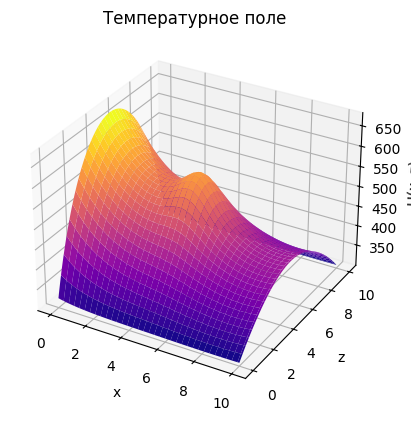

In [264]:
xs = np.array(np.arange(x_start, x_end + h_x/2, h_x))
zs = np.array(np.arange(z_start, z_end + h_z/2, h_z))

u_res = solve()
X, Y = np.meshgrid(xs, zs)
Z = np.array([np.array(T_m) for T_m in u_res[-1]])
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Y, X, Z, cmap='plasma')
ax.set_xlabel('x')
ax.set_ylabel('z')
ax.set_zlabel('U(x, z)')
ax.set_title('Температурное поле')
plt.show()
plt.close()

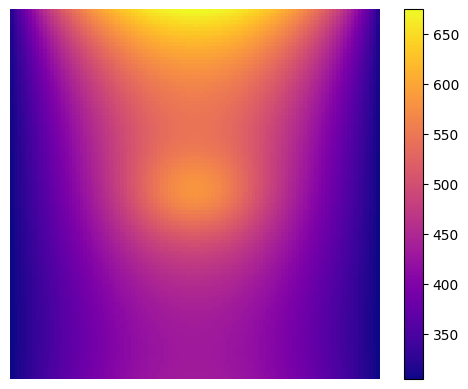

In [267]:
u = np.array(u_res)
plt.imshow(u[-1], cmap='plasma')
plt.axis('off')
plt.colorbar()
plt.show()

In [226]:
M = 51
N = 51
h_x = (x_end - x_start) / (N - 1)
h_z = (z_end - z_start) / (M - 1)
tau = 10

prev_y = solve()[-1]
h_x /= 2
N = int(((x_end - x_start) / h_x) + 1)
print(f"{'h_x':^20}|{'h_z':^20}|{'tau':^20}")

while h_x > 0.01:
    y = solve()[-1]
    
    stop = True
    for i in range(0, N, 2):
        if abs((prev_y[i//2][len(y)//2] - y[i][len(y)//2])/y[i][len(y)//2]) > EPS:
            stop = False
            break
    prev_y = y
    
    if stop:
        print(f"{h_x:^15.5f}|{h_z:^15.5f}|{tau:^15.5f}")
        break
        
    h_x /= 2
    N = int(((x_end - x_start) / h_x) + 1)

solve: max time index: 89
        h_x         |        h_z         |        tau         


KeyboardInterrupt: 

In [229]:
# M = 50
# N = 50
# h_x = (x_end - x_start) / (N - 1)
# h_z = (z_end - z_start) / (M - 1)
h_x = 0.1
h_z = 0.1
N = int(((x_end - x_start) / h_x) + 1)
M = int(((z_end - z_start) / h_z) + 1)
tau = 10

prev_y = solve()[-1]
tau /= 2
print(f"{'h_x':^20}|{'h_z':^20}|{'tau':^20}")

while tau > 1:
    y = solve()[-1]
    
    stop = True
    for ix in range(0, N, 2):
        for iz in range(0, M, 2):
            if abs((y[ix][iz] - prev_y[ix][iz]) / y[ix][iz]) > EPS:
                stop = False
                break
    prev_y = y
    
    if stop:
        print(f"{h_x:^15.5f}|{h_z:^15.5f}|{tau:^15.5f}")
        break
        
    tau /= 2

if not stop:
    print(f"?!: {h_x:^15.5f}|{h_z:^15.5f}|{tau:^15.5f}")

solve: max time index: 89
        h_x         |        h_z         |        tau         
solve: max time index: 176
    0.10000    |    0.10000    |    5.00000    


5 5
